<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/ALB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author: Tewabe Melkamu**

Date: 3/13/2025

ALB_Data Collection

In [4]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-mftewabe')

In [ ]:
# -------------------------------------------------------------------
# Define the study region (Taiwan)
# -------------------------------------------------------------------
# Using the FAO GAUL 2015 dataset to filter Taiwan
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# # -------------------------------------------------------------------
# # Load ESA WorldCover and create a land mask
# # -------------------------------------------------------------------
# # Load the first image from ESA WorldCover and clip it to Taiwan.
# worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)

# # Class definitions from ESA WorldCover:
# # 50 = Built-up, 80 = Permanent water bodies.
# # Remove built-up and permanent water by keeping pixels that are **not** 50 and **not** 80.
# mask = worldcover.neq(50).And(worldcover.neq(80))

# -------------------------------------------------------------------
#  Define the seasons
# -------------------------------------------------------------------
seasons = {
    "Winter": ('12-01', '02-39'),  # Adjusted February end date
    "Spring": ('03-01', '05-31'),
    "Summer": ('06-01', '08-31'),
    "Autumn": ('09-01', '11-30')  # November has 30 days
}

# -------------------------------------------------------------------
# Loop through each year from 2000 to 2025 and process seasonal ALBEDO
# -------------------------------------------------------------------
for year in range(2000, 2025):
    print(f"Processing year: {year}")

    for season, (start, end) in seasons.items():
        print(f"  Processing {season} of {year}")

        # Define the seasonal date range
        start_date = ee.Date(f"{year}-{start}")
        end_date = ee.Date(f"{year}-{end}")

        # Compute the mean ALBEDO for the season
        seasonal_albedo = (ee.ImageCollection("MODIS/061/MCD43A3")
                            .filterDate(start_date, end_date)
                            .filterBounds(taiwan)
                            .select('Albedo_WSA_Band1')
                            .mean()
                            .clip(taiwan))

        # Scale ALBEDO values (MODIS Albedo scale factor is 0.001)
        albedo_scaled = seasonal_albedo.multiply(0.001)

        # Apply the land mask (remove built-up areas & water bodies)
        #albedo_masked = albedo_scaled.updateMask(mask)

        # -------------------------------------------------------------------
        #  Export to Google Drive
        # -------------------------------------------------------------------
        task = ee.batch.Export.image.toDrive(
            image=albedo_scaled,
            description=f'ALB_{year}_{season}',  # Unique name per year & season
            folder='Taiwan_ALB',  # Update this to your desired Drive folder
            fileNamePrefix=f'ALB_{year}_{season}',
            region=taiwan.geometry().bounds().getInfo()['coordinates'],
            scale=1000,  # MODIS resolution (~1 km)
            crs='EPSG:32651',  # UTM Zone 51N for Taiwan
            maxPixels=1e13
        )

        task.start()
        print(f"Export task for {year} - {season} started.")



# Single year

In [ ]:
# 1. Define Ethiopia's boundary using a FeatureCollection.
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
ethiopia = countries.filter(ee.Filter.eq('country_na', 'Ethiopia'))

# 2. Load the MODIS Surface Albedo dataset (MCD43A3), filter by date (2020) and location (Ethiopia).
dataset = ee.ImageCollection('MODIS/061/MCD43A3') \
    .filter(ee.Filter.date('2020-01-01', '2020-12-31')) \
    .filterBounds(ethiopia.geometry())

# Select the albedo band (shortwave black-sky albedo), compute the mean over the period, and clip to Ethiopia.
albedo = dataset.select('Albedo_WSA_Band1').mean().clip(ethiopia.geometry())

# Multiply by 0.001 to convert the raw values to physical units.
albedo_scaled = albedo.multiply(0.001)

# 3. Create a mask to remove water bodies.
# Load ESA WorldCover and clip to Ethiopia.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(ethiopia)
# In ESA WorldCover, class 80 represents permanent water bodies.
mask = worldcover.neq(80)
# Apply the water body mask to the albedo image.
ALB_masked = albedo_scaled.updateMask(mask)

# 4. Visualization parameters for surface albedo.
albedo_vis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'yellow', 'orange', 'red']
}

# 5. Create an interactive map centered on Ethiopia.
Map = geemap.Map(center=[9.0, 40.0], zoom=6)
Map.addLayer(ALB_masked, albedo_vis, 'Masked Surface Albedo')
Map.addLayer(ethiopia, {}, 'Ethiopia Boundary')
Map.addLayerControl()  # Enable layer control

# Display the map (in a Jupyter Notebook, the last statement displays the map)
#Map
# 6. Export the masked, yearly-mean NDWI image to Google Drive.
export_task = ee.batch.Export.image.toDrive(
    image=ALB_masked,
    description='ALB_2020',
    folder='DEM',
    fileNamePrefix='ALB_2020',
    region=ethiopia.geometry().bounds().getInfo()['coordinates'],
    scale=1000,  # Adjust scale (500 m is typical for MODIS products)
    crs='EPSG:32637',
    maxPixels=1e13
)
export_task.start()
print("export started")

In [ ]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.1 MB/s eta 0:00:00


Metadata:
driver: GTiff
dtype: float64
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


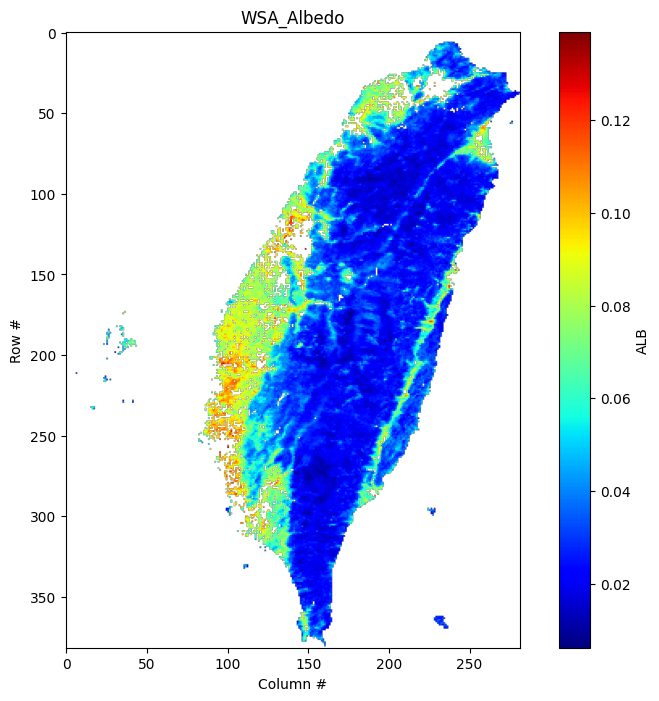

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/Taiwan_ALB/ALB_2000.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
ndvi_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(ndvi_masked, cmap=cmap)
plt.colorbar(img, label='ALB')
plt.title('WSA_Albedo')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

